# Análisis de Errores - Modelos de Predicción de Precio de la Luz

Este notebook analiza los errores de todos los modelos entrenados para la predicción del precio de la electricidad.

**Objetivos**:
- Calcular MAE y RMSE para cada modelo
- Visualizar distribuciones del error (no error absoluto)
- Calcular percentiles p5 y p90 del error
- Comparar el rendimiento entre modelos


## 1. Importaciones y Configuración


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Rutas
BASE_DIR = Path('.')
DATA_DIR = Path('../../data')
MODEL_DIR = Path('../../app/models')

# Rutas específicas de datos
PRECIOS_DIR = DATA_DIR / 'precio_luz' / 'data_parquet_clean' / 'precios_luz'
REE_DIR = DATA_DIR / 'ree' / 'data_parquet_clean'

print("Configuración completada")
print(f"Modelo: {MODEL_DIR}")
print(f"Datos precios: {PRECIOS_DIR}")
print(f"Datos REE: {REE_DIR}")


Configuración completada
Modelo: ../../app/models
Datos precios: ../../data/precio_luz/data_parquet_clean/precios_luz
Datos REE: ../../data/ree/data_parquet_clean


## 2. Carga de Datos y Preparación


In [3]:
# Función para cargar datos particionados por año (robusta para Google Drive)
def load_partitioned_data(base_dir, pattern='*.parquet'):
    """Carga todos los archivos parquet de un directorio particionado por año"""
    all_files = []
    if base_dir.exists():
        for year_dir in sorted(base_dir.glob('year=*')):
            files = list(year_dir.glob(pattern))
            all_files.extend(files)
    
    if not all_files:
        raise FileNotFoundError(f"No se encontraron archivos en {base_dir}")
    
    print(f"Cargando {len(all_files)} archivos desde {base_dir}...")
    dfs = []
    failed_files = []
    
    for file in sorted(all_files):
        try:
            # Intentar cargar con pyarrow primero
            df = pd.read_parquet(file, engine='pyarrow')
            dfs.append(df)
            if len(dfs) % 10 == 0:
                print(f"  Progreso: {len(dfs)}/{len(all_files)} archivos cargados...")
        except Exception as e:
            failed_files.append((file, str(e)))
            # Si falla, intentar con fastparquet como alternativa
            try:
                df = pd.read_parquet(file, engine='fastparquet')
                dfs.append(df)
                print(f"  ✓ {file.name} cargado con fastparquet")
            except:
                print(f"  ✗ Error cargando {file.name}: {e}")
    
    if not dfs:
        raise ValueError(f"No se pudieron cargar archivos desde {base_dir}")
    
    if failed_files:
        print(f"⚠ {len(failed_files)} archivos dieron error pero se cargaron {len(dfs)} exitosamente")
    
    result = pd.concat(dfs, ignore_index=True)
    print(f"✓ Cargados {len(result)} registros en total")
    return result

# Cargar datos de precios (particionados por año)
print("Cargando datos de precios...")
df_precios = load_partitioned_data(PRECIOS_DIR)

# Cargar datos REE (combinar demanda, generación, emisiones, almacenamiento)
print("\nCargando datos REE...")
ree_dfs = []

# Demanda
demanda_dir = REE_DIR / 'demanda'
if demanda_dir.exists():
    df_demanda = load_partitioned_data(demanda_dir)
    ree_dfs.append(df_demanda)

# Generación
generacion_dir = REE_DIR / 'generacion'
if generacion_dir.exists():
    df_generacion = load_partitioned_data(generacion_dir)
    ree_dfs.append(df_generacion)

# Emisiones
emision_dir = REE_DIR / 'emision'
if emision_dir.exists():
    df_emision = load_partitioned_data(emision_dir)
    ree_dfs.append(df_emision)

# Almacenamiento
almacenamiento_dir = REE_DIR / 'almacenamiento'
if almacenamiento_dir.exists():
    df_almacenamiento = load_partitioned_data(almacenamiento_dir)
    ree_dfs.append(df_almacenamiento)

# Combinar todos los datos REE
if ree_dfs:
    # Merge por datetime si tienen esa columna común
    df_ree = ree_dfs[0].copy()
    
    # Identificar columna de tiempo común (Hora, datetime, ts_utc)
    time_cols = []
    for col in ['Hora', 'datetime', 'ts_utc']:
        if col in df_ree.columns:
            time_cols.append(col)
            break
    
    if not time_cols:
        # Buscar cualquier columna datetime
        for col in df_ree.columns:
            if pd.api.types.is_datetime64_any_dtype(df_ree[col]):
                time_cols.append(col)
                break
    
    time_col = time_cols[0] if time_cols else None
    
    for idx, df in enumerate(ree_dfs[1:], 1):
        df_temp = df.copy()
        
        # Identificar columna de tiempo en este DataFrame
        df_time_col = None
        for col in ['Hora', 'datetime', 'ts_utc']:
            if col in df_temp.columns:
                df_time_col = col
                break
        
        if not df_time_col:
            for col in df_temp.columns:
                if pd.api.types.is_datetime64_any_dtype(df_temp[col]):
                    df_time_col = col
                    break
        
        if time_col and df_time_col:
            # Renombrar la columna de tiempo del segundo DataFrame si es diferente
            if df_time_col != time_col:
                df_temp = df_temp.rename(columns={df_time_col: time_col})
            
            # Hacer merge por la columna de tiempo
            # Eliminar columnas duplicadas antes del merge (excepto la columna de tiempo)
            cols_to_merge = [col for col in df_temp.columns if col != time_col]
            # Eliminar columnas que ya existen en df_ree (excepto time_col)
            existing_cols = set(df_ree.columns) - {time_col}
            cols_to_merge = [col for col in cols_to_merge if col not in existing_cols]
            
            if cols_to_merge:
                df_ree = pd.merge(
                    df_ree, 
                    df_temp[[time_col] + cols_to_merge], 
                    on=time_col, 
                    how='outer',
                    suffixes=('', f'_dup{idx}')
                )
        else:
            # Si no hay columna de tiempo común, hacer concat simple
            # Eliminar columnas duplicadas
            new_cols = [col for col in df_temp.columns if col not in df_ree.columns]
            if new_cols:
                df_ree = pd.concat([df_ree, df_temp[new_cols]], axis=1)
    
    print(f"✓ Datos REE combinados: {len(df_ree)} registros, {len(df_ree.columns)} columnas")
else:
    raise FileNotFoundError(f"No se encontraron datos REE en {REE_DIR}")

print(f"Precios cargados: {len(df_precios)} registros")
print(f"REE cargados: {len(df_ree)} registros")

# Verificar columnas disponibles
print(f"\nColumnas en df_precios: {df_precios.columns.tolist()}")

# Identificar columna de precio objetivo
# Según el modelo entrenado, el precio objetivo puede ser 'price', 'PCB', o alguna de las columnas GEN/NOC/VHC
price_candidates = ['price', 'PCB', 'Precio', 'precio']
price_col = None
for col in price_candidates:
    if col in df_precios.columns:
        price_col = col
        break

# Si no se encuentra, usar la primera columna numérica que parezca precio
if price_col is None:
    numeric_cols = df_precios.select_dtypes(include=[np.number]).columns.tolist()
    # Excluir columnas que no son precios (como índices, horas, etc.)
    exclude_cols = ['Hora', 'hora', 'hour', 'index', 'id']
    price_cols = [col for col in numeric_cols if col not in exclude_cols]
    if price_cols:
        # Preferir columnas que contengan 'GEN', 'NOC', 'VHC' o 'price'
        preferred = [col for col in price_cols if any(x in col.upper() for x in ['GEN', 'NOC', 'VHC', 'PRICE', 'PCB'])]
        price_col = preferred[0] if preferred else price_cols[0]
        print(f"⚠ No se encontró columna 'price' estándar. Usando '{price_col}' como precio objetivo")
    else:
        raise ValueError("No se encontró ninguna columna numérica que pueda ser precio")

# Renombrar a 'price' para consistencia
if price_col != 'price':
    df_precios['price'] = df_precios[price_col]
    print(f"✓ Columna '{price_col}' renombrada a 'price'")

# Limpiar y preparar datos (similar al pipeline de entrenamiento)
# Convertir timestamp si es necesario
if 'datetime' in df_precios.columns:
    # Ya existe datetime, solo convertir si es necesario
    if df_precios['datetime'].dtype != 'datetime64[ns]':
        df_precios['datetime'] = pd.to_datetime(df_precios['datetime'])
        if df_precios['datetime'].dt.tz is not None:
            df_precios['datetime'] = df_precios['datetime'].dt.tz_localize(None)
    print("✓ Columna 'datetime' ya existe")
elif 'ts_utc' in df_precios.columns:
    df_precios['datetime'] = pd.to_datetime(df_precios['ts_utc'])
    if df_precios['datetime'].dt.tz is not None:
        df_precios['datetime'] = df_precios['datetime'].dt.tz_localize(None)
    print("✓ Columna 'datetime' creada desde 'ts_utc'")
elif 'Hora' in df_precios.columns and pd.api.types.is_datetime64_any_dtype(df_precios['Hora']):
    # Hora ya es datetime, usarla directamente
    print("✓ Columna 'Hora' es datetime. Usándola directamente como 'datetime'...")
    df_precios['datetime'] = df_precios['Hora']
    # Eliminar timezone si existe
    if df_precios['datetime'].dt.tz is not None:
        df_precios['datetime'] = df_precios['datetime'].dt.tz_localize(None)
    print("✓ Columna 'datetime' creada desde 'Hora'")
elif 'Dia' in df_precios.columns and 'Hora' in df_precios.columns:
    # Estructura con columnas separadas Dia y Hora
    print("✓ Detectadas columnas 'Dia' y 'Hora'. Combinando para crear 'datetime'...")
    # Convertir Dia a datetime
    df_precios['Dia'] = pd.to_datetime(df_precios['Dia'], errors='coerce')
    
    # Verificar formato de Hora
    if len(df_precios) > 0:
        hora_sample = str(df_precios['Hora'].iloc[0])
    else:
        hora_sample = ''
    
    if df_precios['Hora'].dtype == 'object' and ':' in hora_sample:
        # Formato HH:MM o similar
        print("  Formato Hora detectado: HH:MM")
        df_precios['datetime'] = pd.to_datetime(
            df_precios['Dia'].astype(str) + ' ' + df_precios['Hora'].astype(str),
            errors='coerce'
        )
    elif pd.api.types.is_datetime64_any_dtype(df_precios['Hora']):
        # Hora ya es datetime, combinar con Dia para asegurar fecha correcta
        print("  Formato Hora detectado: datetime")
        # Extraer solo la hora de 'Hora' y combinarla con 'Dia'
        df_precios['datetime'] = pd.to_datetime(df_precios['Dia'].astype(str)) + pd.to_timedelta(
            df_precios['Hora'].dt.hour, unit='h'
        )
    else:
        # Hora como número (0-23 o similar)
        print("  Formato Hora detectado: numérico")
        # Convertir Hora a numérico si no lo es
        df_precios['Hora'] = pd.to_numeric(df_precios['Hora'], errors='coerce')
        df_precios['datetime'] = df_precios['Dia'] + pd.to_timedelta(df_precios['Hora'], unit='h')
    
    # Eliminar filas con datetime inválido
    invalid_count = df_precios['datetime'].isna().sum()
    if invalid_count > 0:
        print(f"  ⚠ Eliminando {invalid_count} filas con datetime inválido")
        df_precios = df_precios.dropna(subset=['datetime'])
    
    print(f"✓ Columna 'datetime' creada desde 'Dia' y 'Hora'")
elif 'Dia' in df_precios.columns:
    # Solo tiene Dia, asumir hora 0
    print("✓ Detectada columna 'Dia'. Creando 'datetime'...")
    df_precios['datetime'] = pd.to_datetime(df_precios['Dia'])
    print("✓ Columna 'datetime' creada desde 'Dia'")
else:
    # Intentar otras columnas de fecha
    date_cols = [col for col in df_precios.columns if 'date' in col.lower() or 'time' in col.lower() or 'ts' in col.lower()]
    if date_cols:
        print(f"✓ Creando 'datetime' desde '{date_cols[0]}'")
        df_precios['datetime'] = pd.to_datetime(df_precios[date_cols[0]])
        if df_precios['datetime'].dt.tz is not None:
            df_precios['datetime'] = df_precios['datetime'].dt.tz_localize(None)
    else:
        # Si no hay columna de fecha, intentar usar el índice si es datetime
        if isinstance(df_precios.index, pd.DatetimeIndex):
            df_precios['datetime'] = df_precios.index
            df_precios = df_precios.reset_index(drop=True)
            print("✓ Columna 'datetime' creada desde el índice")
        else:
            # Último recurso: crear datetime secuencial desde una fecha base
            print("⚠ No se encontró columna de fecha. Creando datetime secuencial...")
            start_date = pd.Timestamp('2024-01-01')
            df_precios['datetime'] = pd.date_range(start=start_date, periods=len(df_precios), freq='H')
            print(f"⚠ Datetime creado secuencialmente desde {start_date}")

# Verificar que datetime existe antes de ordenar
if 'datetime' not in df_precios.columns:
    raise ValueError("No se pudo crear la columna 'datetime'. Columnas disponibles: " + str(df_precios.columns.tolist()))

# Ordenar por fecha
df_precios = df_precios.sort_values('datetime').reset_index(drop=True)

# Eliminar duplicados
df_precios = df_precios.drop_duplicates(subset=['datetime'])

print(f"\n✓ Datos preparados: {len(df_precios)} registros únicos")
print(f"✓ Rango temporal: {df_precios['datetime'].min()} a {df_precios['datetime'].max()}")


Cargando datos de precios...
Cargando 6 archivos desde ../../data/precio_luz/data_parquet_clean/precios_luz...
✓ Cargados 50904 registros en total

Cargando datos REE...
Cargando 6 archivos desde ../../data/ree/data_parquet_clean/demanda...
✓ Cargados 610848 registros en total
Cargando 6 archivos desde ../../data/ree/data_parquet_clean/generacion...
✓ Cargados 610848 registros en total
Cargando 6 archivos desde ../../data/ree/data_parquet_clean/emision...
✓ Cargados 610848 registros en total
Cargando 6 archivos desde ../../data/ree/data_parquet_clean/almacenamiento...
✓ Cargados 610848 registros en total
✓ Datos REE combinados: 610848 registros, 51 columnas
Precios cargados: 50904 registros
REE cargados: 610848 registros

Columnas en df_precios: ['Hora', 'Dia', 'GEN', 'NOC', 'VHC', 'COFGEN', 'COFNOC', 'COFVHC', 'PMHGEN', 'PMHNOC', 'PMHVHC', 'SAHGEN', 'SAHNOC', 'SAHVHC', 'FOMGEN', 'FOMNOC', 'FOMVHC', 'FOSGEN', 'FOSNOC', 'FOSVHC', 'INTGEN', 'INTNOC', 'INTVHC', 'PCAPGEN', 'PCAPNOC', 'PCAP

## 3. Feature Engineering (Replicar Pipeline de Entrenamiento)


In [4]:
# Preparar datos REE para merge
# Crear columna datetime si no existe
print(f"\nPreparando df_ree... Columnas: {df_ree.columns.tolist()[:10]}...")

if 'datetime' in df_ree.columns:
    # Ya existe datetime, solo convertir si es necesario
    if df_ree['datetime'].dtype != 'datetime64[ns]':
        df_ree['datetime'] = pd.to_datetime(df_ree['datetime'])
        if df_ree['datetime'].dt.tz is not None:
            df_ree['datetime'] = df_ree['datetime'].dt.tz_localize(None)
    print("✓ Columna 'datetime' ya existe en df_ree")
elif 'ts_utc' in df_ree.columns:
    df_ree['datetime'] = pd.to_datetime(df_ree['ts_utc'])
    if df_ree['datetime'].dt.tz is not None:
        df_ree['datetime'] = df_ree['datetime'].dt.tz_localize(None)
    print("✓ Columna 'datetime' creada desde 'ts_utc' en df_ree")
elif 'Hora' in df_ree.columns:
    # Intentar usar Hora como datetime
    # Manejar caso de columnas duplicadas
    hora_col = df_ree['Hora']
    if isinstance(hora_col, pd.DataFrame):
        # Si hay múltiples columnas 'Hora', usar la primera
        hora_col = hora_col.iloc[:, 0]
        print("  ⚠ Múltiples columnas 'Hora' detectadas. Usando la primera.")
    
    print(f"✓ Detectada columna 'Hora' en df_ree. Tipo: {hora_col.dtype}")
    
    if pd.api.types.is_datetime64_any_dtype(hora_col):
        # Hora ya es datetime, usarla directamente
        print("  Formato detectado: datetime")
        df_ree['datetime'] = hora_col
        if df_ree['datetime'].dt.tz is not None:
            df_ree['datetime'] = df_ree['datetime'].dt.tz_localize(None)
        print("✓ Columna 'datetime' creada desde 'Hora' en df_ree")
    else:
        # Intentar convertir Hora a datetime
        print("  Intentando convertir 'Hora' a datetime...")
        try:
            df_ree['datetime'] = pd.to_datetime(hora_col, errors='coerce')
            invalid_count = df_ree['datetime'].isna().sum()
            if invalid_count > 0:
                print(f"  ⚠ {invalid_count} valores no pudieron convertirse a datetime")
                df_ree = df_ree.dropna(subset=['datetime'])
            print("✓ Columna 'datetime' creada desde 'Hora' (convertida) en df_ree")
        except Exception as e:
            print(f"  ✗ Error convirtiendo 'Hora': {e}")
            # Si falla, intentar con Dia+Hora
            if 'Dia' in df_ree.columns:
                print("  Intentando combinar 'Dia' y 'Hora'...")
                dia_col = df_ree['Dia']
                if isinstance(dia_col, pd.DataFrame):
                    dia_col = dia_col.iloc[:, 0]
                df_ree['Dia'] = pd.to_datetime(dia_col, errors='coerce')
                df_ree['datetime'] = df_ree['Dia'] + pd.to_timedelta(pd.to_numeric(hora_col, errors='coerce'), unit='h')
                invalid_count = df_ree['datetime'].isna().sum()
                if invalid_count > 0:
                    df_ree = df_ree.dropna(subset=['datetime'])
                print("✓ Columna 'datetime' creada desde 'Dia' y 'Hora' en df_ree")
            else:
                raise ValueError(f"No se pudo crear 'datetime' desde 'Hora'. Error: {e}")
elif 'Dia' in df_ree.columns and 'Hora' in df_ree.columns:
    # Estructura con columnas separadas Dia y Hora
    print("✓ Detectadas columnas 'Dia' y 'Hora' en df_ree. Combinando...")
    df_ree['Dia'] = pd.to_datetime(df_ree['Dia'], errors='coerce')
    if pd.api.types.is_datetime64_any_dtype(df_ree['Hora']):
        df_ree['datetime'] = pd.to_datetime(df_ree['Dia'].astype(str)) + pd.to_timedelta(
            df_ree['Hora'].dt.hour, unit='h'
        )
    else:
        df_ree['Hora'] = pd.to_numeric(df_ree['Hora'], errors='coerce')
        df_ree['datetime'] = df_ree['Dia'] + pd.to_timedelta(df_ree['Hora'], unit='h')
    invalid_count = df_ree['datetime'].isna().sum()
    if invalid_count > 0:
        print(f"  ⚠ Eliminando {invalid_count} filas con datetime inválido en df_ree")
        df_ree = df_ree.dropna(subset=['datetime'])
    print("✓ Columna 'datetime' creada desde 'Dia' y 'Hora' en df_ree")
else:
    # Buscar otras columnas de fecha
    date_cols = [col for col in df_ree.columns if 'date' in col.lower() or 'time' in col.lower() or 'ts' in col.lower()]
    if date_cols:
        print(f"✓ Creando 'datetime' desde '{date_cols[0]}' en df_ree")
        df_ree['datetime'] = pd.to_datetime(df_ree[date_cols[0]])
        if df_ree['datetime'].dt.tz is not None:
            df_ree['datetime'] = df_ree['datetime'].dt.tz_localize(None)
    else:
        # Si no hay columna de fecha, usar el índice si es datetime
        if isinstance(df_ree.index, pd.DatetimeIndex):
            df_ree['datetime'] = df_ree.index
            df_ree = df_ree.reset_index(drop=True)
            print("✓ Columna 'datetime' creada desde el índice en df_ree")
        else:
            raise ValueError(f"No se pudo crear la columna 'datetime' en df_ree. Columnas disponibles: {df_ree.columns.tolist()[:20]}")

# Verificar que datetime existe antes de ordenar
if 'datetime' not in df_ree.columns:
    raise ValueError("No se pudo crear la columna 'datetime' en df_ree. Columnas disponibles: " + str(df_ree.columns.tolist()[:20]))

df_ree = df_ree.sort_values('datetime').reset_index(drop=True)
print(f"✓ df_ree ordenado por datetime: {len(df_ree)} registros")

# Merge con merge_asof (tolerancia ±1h)
df_merged = pd.merge_asof(
    df_precios.sort_values('datetime'),
    df_ree.sort_values('datetime'),
    on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta('1h')
)

print(f"Datos combinados: {len(df_merged)} registros")

# Crear features temporales
df_merged['hour'] = df_merged['datetime'].dt.hour
df_merged['dow'] = df_merged['datetime'].dt.dayofweek
df_merged['month'] = df_merged['datetime'].dt.month
df_merged['is_weekend'] = (df_merged['dow'] >= 5).astype(int)

# Features cíclicas
df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged['hour'] / 24)
df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged['hour'] / 24)
df_merged['dow_sin'] = np.sin(2 * np.pi * df_merged['dow'] / 7)
df_merged['dow_cos'] = np.cos(2 * np.pi * df_merged['dow'] / 7)

# Lags de precio
for lag in [1, 2, 3, 24, 48, 168]:
    df_merged[f'price_lag{lag}'] = df_merged['price'].shift(lag)

# Medias móviles
for window in [3, 6, 24]:
    df_merged[f'price_rolling_mean_{window}h'] = df_merged['price'].rolling(window=window, min_periods=1).mean()
    df_merged[f'price_rolling_std_{window}h'] = df_merged['price'].rolling(window=window, min_periods=1).std()

# Series de Fourier (simplificado)
for k in [1, 2]:
    df_merged[f'fourier_w_sin{k}'] = np.sin(2 * np.pi * k * df_merged['hour'] / 24)
    df_merged[f'fourier_w_cos{k}'] = np.cos(2 * np.pi * k * df_merged['hour'] / 24)

print("Features creadas")



Preparando df_ree... Columnas: ['Hora', 'Real', 'Prevista', 'Programada', 'Eólica', 'Nuclear', 'Carbón', 'Ciclo combinado', 'Intercambios int', 'Solar fotovoltaica']...
✓ Detectada columna 'Hora' en df_ree. Tipo: datetime64[ns]
  Formato detectado: datetime
✓ Columna 'datetime' creada desde 'Hora' en df_ree
✓ df_ree ordenado por datetime: 610848 registros
Datos combinados: 50904 registros
Features creadas


## 4. Partición de Datos (Train/Test)


In [5]:
# Eliminar filas con NaN en el target
df_merged = df_merged.dropna(subset=['price'])

# Definir fecha de corte para test (similar al entrenamiento)
# Usar los últimos datos como test
test_size = 0.2
split_idx = int(len(df_merged) * (1 - test_size))
split_date = df_merged.iloc[split_idx]['datetime']

df_train = df_merged[df_merged['datetime'] < split_date].copy()
df_test = df_merged[df_merged['datetime'] >= split_date].copy()

print(f"Train: {len(df_train)} registros ({df_train['datetime'].min()} a {df_train['datetime'].max()})")
print(f"Test: {len(df_test)} registros ({df_test['datetime'].min()} a {df_test['datetime'].max()})")

# Separar features y target
target_col = 'price'

# Obtener columnas únicas (evitar duplicados)
unique_cols = df_test.columns.unique()

# Filtrar columnas para features
feature_cols = []
exclude_cols = [target_col, 'datetime', 'ts_utc', 'Hora', 'Dia']

for col in unique_cols:
    # Excluir columnas específicas
    if col in exclude_cols:
        continue
    
    # Verificar que la columna existe y no está completamente vacía
    try:
        col_data = df_test[col]
        # Si hay múltiples columnas con el mismo nombre, usar la primera
        if isinstance(col_data, pd.DataFrame):
            col_data = col_data.iloc[:, 0]
        
        # Verificar que no todas las filas son NaN
        if col_data.isna().all():
            continue
        
        # Solo incluir columnas numéricas
        if col_data.dtype in ['int64', 'float64', 'int32', 'float32']:
            feature_cols.append(col)
    except Exception as e:
        # Si hay error accediendo a la columna, omitirla
        continue

X_test = df_test[feature_cols].fillna(0)
y_test = df_test[target_col].values

print(f"\nFeatures seleccionadas: {len(feature_cols)}")
print(f"Registros de test: {len(X_test)}")


Train: 40723 registros (2020-01-01 00:00:00 a 2024-08-23 18:00:00)
Test: 10181 registros (2024-08-23 19:00:00 a 2025-10-21 23:00:00)

Features seleccionadas: 129
Registros de test: 10181


## 5. Carga de Modelos Entrenados


In [6]:
# Diccionario para almacenar modelos
models = {}

# Cargar modelo XGBoost (modelo principal)
xgb_model_path = MODEL_DIR / 'precio_luz_xgb.pkl'
print(f"Buscando modelo en: {xgb_model_path.absolute()}")

if xgb_model_path.exists():
    try:
        # Verificar si estamos en Google Drive
        is_google_drive = '.shortcut-targets-by-id' in str(xgb_model_path.absolute())
        
        if is_google_drive:
            print("⚠ Google Drive detectado. Cargando modelo...")
            # Intentar cargar directamente
            try:
                xgb_bundle = joblib.load(xgb_model_path)
                print("✓ Modelo cargado desde Google Drive")
            except Exception as e:
                if 'timeout' in str(e).lower() or 'timed out' in str(e).lower():
                    print(f"⚠ Timeout cargando modelo. Esto puede tardar...")
                    # Reintentar una vez más
                    xgb_bundle = joblib.load(xgb_model_path)
                else:
                    raise e
        else:
            xgb_bundle = joblib.load(xgb_model_path)
        
        # El bundle puede contener el modelo directamente o en un diccionario
        if isinstance(xgb_bundle, dict):
            models['XGBoost'] = xgb_bundle.get('model') or xgb_bundle.get('booster') or xgb_bundle
        else:
            models['XGBoost'] = xgb_bundle
        print("✓ XGBoost cargado correctamente")
    except Exception as e:
        print(f"✗ Error cargando XGBoost: {e}")
        if 'No module named' in str(e):
            module_name = str(e).split("'")[1] if "'" in str(e) else 'xgboost'
            print(f"   💡 Instala con: pip install {module_name}")
else:
    print(f"⚠ XGBoost no encontrado en: {xgb_model_path}")

# Intentar cargar otros modelos si existen
# SARIMAX (si está guardado)
sarimax_path = MODEL_DIR / 'sarimax_model.pkl'
if sarimax_path.exists():
    try:
        models['SARIMAX'] = joblib.load(sarimax_path)
        print("✓ SARIMAX cargado")
    except Exception as e:
        print(f"✗ Error cargando SARIMAX: {e}")

# LSTM/GRU (si están guardados)
try:
    import tensorflow as tf
    from tensorflow import keras
    
    lstm_path = MODEL_DIR / 'lstm_model.keras'
    if lstm_path.exists():
        try:
            models['LSTM'] = keras.models.load_model(lstm_path)
            print("✓ LSTM cargado")
        except Exception as e:
            print(f"✗ Error cargando LSTM: {e}")
    
    gru_path = MODEL_DIR / 'gru_model.keras'
    if gru_path.exists():
        try:
            models['GRU'] = keras.models.load_model(gru_path)
            print("✓ GRU cargado")
        except Exception as e:
            print(f"✗ Error cargando GRU: {e}")
except ImportError:
    print("⚠ TensorFlow no disponible. Se omitirán modelos de redes neuronales.")

# Modelos baseline (se calcularán sobre la marcha)
print(f"\nTotal de modelos cargados: {len(models)}")


Buscando modelo en: /Users/juanolivares/Library/CloudStorage/GoogleDrive-juan.olivares.diez@gmail.com/.shortcut-targets-by-id/11EThalmk4ZcOCOK3_HPRAeAAOnjrg-BW/TFM MBIT/workspace/TFM/TFM_Energia_Entrega_Final/models/Precio de la luz/../../app/models/precio_luz_xgb.pkl
⚠ Google Drive detectado. Cargando modelo...
✓ Modelo cargado desde Google Drive
✓ XGBoost cargado correctamente
⚠ TensorFlow no disponible. Se omitirán modelos de redes neuronales.

Total de modelos cargados: 1


In [7]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## 6. Generación de Predicciones


In [9]:
# Verificar que las variables necesarias estén definidas
if 'models' not in globals() or len(models) == 0:
    raise RuntimeError(
        "Los modelos no están cargados. Por favor ejecuta primero la celda '5. Carga de Modelos Entrenados'."
    )

if 'X_test' not in globals() or 'y_test' not in globals():
    raise RuntimeError(
        "Los datos de test no están preparados. Por favor ejecuta primero la celda '4. Partición de Datos (Train/Test)'."
    )

# Diccionario para almacenar predicciones
predictions = {}

# Predicción XGBoost
if 'XGBoost' in models:
    try:
        import xgboost as xgb
        model = models['XGBoost']
        
        # Intentar diferentes formas de hacer predicción
        print(f"Tipo de modelo: {type(model)}")
        
        if isinstance(model, dict):
            print("Modelo es un diccionario. Analizando estructura...")
            print(f"Claves disponibles: {list(model.keys())[:10]}...")
            
            # Si es un bundle con booster_json
            if 'booster_json' in model:
                print("Reconstruyendo booster desde JSON...")
                try:
                    import tempfile
                    import json
                    
                    # Crear archivo temporal con el JSON
                    booster_json_str = model['booster_json']
                    if isinstance(booster_json_str, str):
                        # Si es string, crear archivo temporal
                        with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as tmp_file:
                            tmp_file.write(booster_json_str)
                            tmp_path = tmp_file.name
                        
                        booster = xgb.Booster()
                        booster.load_model(tmp_path)
                        
                        # Limpiar archivo temporal
                        import os
                        os.unlink(tmp_path)
                        
                        print("✓ Booster reconstruido desde JSON")
                    else:
                        raise ValueError("booster_json no es un string válido")
                    
                    # Preparar datos para predicción
                    print("Preparando datos para predicción...")
                    # Verificar que tenemos las features correctas
                    if 'feature_names' in model:
                        feature_names = model['feature_names']
                        print(f"Features esperadas: {len(feature_names)}")
                        # Asegurar que X_test tenga las mismas columnas en el mismo orden
                        missing_features = set(feature_names) - set(X_test.columns)
                        if missing_features:
                            print(f"⚠ Faltan {len(missing_features)} features. Creando con valor 0...")
                            for feat in missing_features:
                                X_test[feat] = 0.0
                        # Reordenar columnas
                        X_test_ordered = X_test[feature_names]
                    else:
                        X_test_ordered = X_test
                    
                    print(f"Creando DMatrix con {len(X_test_ordered)} registros y {len(X_test_ordered.columns)} features...")
                    dtest = xgb.DMatrix(X_test_ordered)
                    print("Generando predicciones...")
                    y_pred_xgb = booster.predict(dtest)
                    print(f"✓ Predicciones generadas: {len(y_pred_xgb)} valores")
                    
                except Exception as e:
                    print(f"✗ Error reconstruyendo booster desde JSON: {e}")
                    import traceback
                    print(f"Detalles: {traceback.format_exc()}")
                    raise
                    
            elif 'booster' in model:
                print("Usando booster del diccionario...")
                dtest = xgb.DMatrix(X_test)
                y_pred_xgb = model['booster'].predict(dtest)
            else:
                # Intentar usar el diccionario directamente como modelo
                print("Intentando usar diccionario como modelo...")
                if hasattr(model, 'predict'):
                    y_pred_xgb = model.predict(X_test)
                else:
                    raise ValueError("Formato de modelo no reconocido en diccionario")
        elif hasattr(model, 'predict'):
            # Modelo XGBRegressor estándar
            print("Usando modelo XGBRegressor estándar...")
            y_pred_xgb = model.predict(X_test)
        elif hasattr(model, 'booster'):
            # Modelo con booster accesible
            print("Usando booster del modelo...")
            dtest = xgb.DMatrix(X_test)
            y_pred_xgb = model.booster.predict(dtest)
        else:
            raise ValueError(f"Formato de modelo no reconocido: {type(model)}")
        
        predictions['XGBoost'] = y_pred_xgb
        print(f"✓ Predicciones XGBoost generadas: {len(y_pred_xgb)} registros")
    except ImportError:
        print("✗ Error: xgboost no está instalado")
        print("   💡 Instala con: pip install xgboost")
    except Exception as e:
        print(f"✗ Error generando predicciones XGBoost: {e}")
        import traceback
        print(f"   Detalles: {traceback.format_exc()}")

# Predicción SARIMAX (si está disponible)
if 'SARIMAX' in models:
    try:
        # SARIMAX requiere formato de serie temporal
        # Por simplicidad, omitimos si requiere configuración compleja
        print("⚠ SARIMAX requiere configuración específica de series temporales. Omitiendo.")
    except Exception as e:
        print(f"✗ Error generando predicciones SARIMAX: {e}")

# Predicción LSTM/GRU (si están disponibles)
for name in ['LSTM', 'GRU']:
    if name in models:
        try:
            # Requieren escalado y posiblemente reshape
            print(f"⚠ {name} requiere escalado y posiblemente reshape. Omitiendo por simplicidad.")
        except Exception as e:
            print(f"✗ Error generando predicciones {name}: {e}")

# Modelos baseline
# Baseline 1: Media móvil simple
if len(df_test) > 24:
    window = 24
    baseline_ma = df_test['price'].rolling(window=window, min_periods=1).mean().shift(1).values
    # Rellenar primeros valores con la media
    baseline_ma[:window] = df_test['price'].iloc[:window].mean()
    predictions['Baseline (Media Móvil)'] = baseline_ma
    print("✓ Predicciones Baseline (Media Móvil) generadas")

# Baseline 2: Persistencia (último valor conocido)
baseline_persist = df_test['price'].shift(1).bfill().values
predictions['Baseline (Persistencia)'] = baseline_persist
print("✓ Predicciones Baseline (Persistencia) generadas")

print(f"\nTotal de modelos con predicciones: {len(predictions)}")


Tipo de modelo: <class 'dict'>
Modelo es un diccionario. Analizando estructura...
Claves disponibles: ['kind', 'booster_json', 'feature_names', 'meta']...
Reconstruyendo booster desde JSON...
✓ Booster reconstruido desde JSON
Preparando datos para predicción...
Features esperadas: 69
⚠ Faltan 52 features. Creando con valor 0...
Creando DMatrix con 10181 registros y 69 features...
Generando predicciones...
✓ Predicciones generadas: 10181 valores
✓ Predicciones XGBoost generadas: 10181 registros
✓ Predicciones Baseline (Media Móvil) generadas
✓ Predicciones Baseline (Persistencia) generadas

Total de modelos con predicciones: 3


## 7. Cálculo de Errores


In [11]:
# Diccionario para almacenar errores
errors = {}

# Calcular errores (y_real - y_pred) para cada modelo
for name, y_pred in predictions.items():
    # Asegurar que las longitudes coincidan
    min_len = min(len(y_test), len(y_pred))
    error = y_test[:min_len] - y_pred[:min_len]
    errors[name] = error

# Crear DataFrame con todos los errores
df_errors = pd.DataFrame(errors)

print("Errores calculados para todos los modelos")
print(f"\nForma del DataFrame de errores: {df_errors.shape}")
print(f"\nPrimeras filas:")
display(df_errors.head())

print(f"\nEstadísticas descriptivas de los errores:")
display(df_errors.describe())


Errores calculados para todos los modelos

Forma del DataFrame de errores: (10181, 3)

Primeras filas:


,XGBoost,Baseline (Media Móvil),Baseline (Persistencia)
0,28.149198,113.04875,0.00
1,61.434752,122.93875,9.89
2,84.329893,142.29875,19.36
3,16.737091,75.35875,-66.94
4,42.218943,67.98875,-7.37



Estadísticas descriptivas de los errores:


,XGBoost,Baseline (Media Móvil),Baseline (Persistencia)
count,10181.000000,10181.000000,10181.000000
mean,16.071275,0.105008,-0.008370
std,30.619586,49.638253,30.162175
min,-125.294141,-158.103750,-348.200000
25%,-3.005996,-33.697500,-8.730000
50%,11.396299,-3.991667,-0.400000
75%,29.418521,29.358333,8.880000
max,227.915152,262.287500,257.170000


## 8. Cálculo de Métricas (MAE y RMSE)


In [13]:
# Calcular métricas para cada modelo
metrics_results = []

for name in errors.keys():
    error = errors[name]
    
    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(error))
    
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean(error ** 2))
    
    # Percentiles del error (no absoluto)
    p5 = np.percentile(error, 5)
    p90 = np.percentile(error, 90)
    
    # Estadísticas adicionales
    mean_error = np.mean(error)
    std_error = np.std(error)
    median_error = np.median(error)
    
    metrics_results.append({
        'Modelo': name,
        'MAE': mae,
        'RMSE': rmse,
        'Error Medio': mean_error,
        'Desv. Est. Error': std_error,
        'Mediana Error': median_error,
        'p5': p5,
        'p90': p90
    })

df_metrics = pd.DataFrame(metrics_results)
df_metrics = df_metrics.sort_values('MAE')

print("Métricas calculadas para todos los modelos:")
display(df_metrics.round(2))

# Guardar métricas
output_dir = MODEL_DIR / 'error_analysis'
output_dir.mkdir(parents=True, exist_ok=True)
df_metrics.to_csv(output_dir / 'metrics_errores_precio.csv', index=False)
print(f"\n✓ Métricas guardadas en: {output_dir / 'metrics_errores_precio.csv'}")


Métricas calculadas para todos los modelos:


,Modelo,MAE,RMSE,Error Medio,Desv. Est. Error,Mediana Error,p5,p90
2,Baseline (Persistencia),18.73,30.16,-0.01,30.16,-0.40,-60.00,32.69
0,XGBoost,24.42,34.58,16.07,30.62,11.40,-24.41,54.79
1,Baseline (Media Móvil),38.99,49.64,0.11,49.64,-3.99,-74.33,65.45



✓ Métricas guardadas en: ../../app/models/error_analysis/metrics_errores_precio.csv


## 9. Visualización de Distribuciones del Error


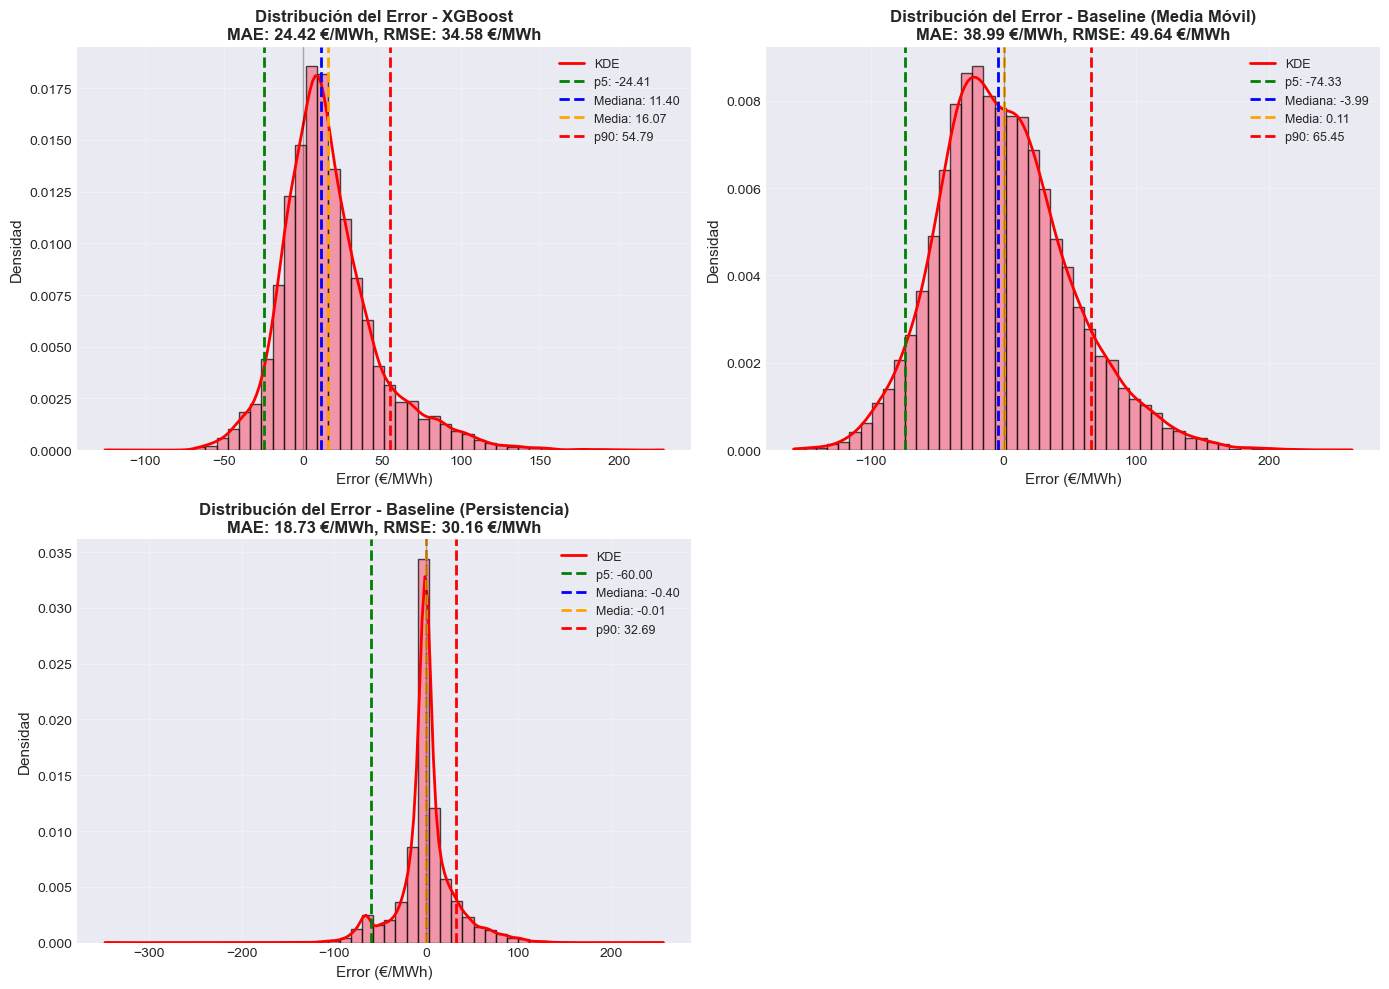

✓ Gráfico guardado en: ../../app/models/error_analysis/distribuciones_errores_precio.png


In [14]:
# Histogramas de distribución del error para cada modelo
n_models = len(errors)
n_cols = 2
n_rows = max(1, (n_models + 1) // 2)  # Al menos 1 fila

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))

# Convertir axes a lista plana para manejar todos los casos
if n_models == 1:
    # Caso especial: un solo modelo
    if n_cols == 1:
        axes_list = [axes]
    else:
        # Si hay 2 columnas pero 1 modelo, usar solo el primer subplot
        axes_list = [axes[0] if isinstance(axes, np.ndarray) else axes]
else:
    # Múltiples modelos: convertir a lista plana
    if isinstance(axes, np.ndarray):
        axes_list = axes.flatten().tolist()
    else:
        axes_list = [axes]

for idx, (name, error) in enumerate(errors.items()):
    if idx >= len(axes_list):
        break
    ax = axes_list[idx]
    
    # Histograma
    ax.hist(error, bins=50, alpha=0.7, edgecolor='black', density=True)
    
    # Línea de densidad (KDE)
    from scipy import stats
    try:
        kde = stats.gaussian_kde(error)
        x_range = np.linspace(error.min(), error.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    except:
        pass
    
    # Líneas verticales para percentiles
    p5 = np.percentile(error, 5)
    p90 = np.percentile(error, 90)
    median = np.median(error)
    mean = np.mean(error)
    
    ax.axvline(p5, color='green', linestyle='--', linewidth=2, label=f'p5: {p5:.2f}')
    ax.axvline(median, color='blue', linestyle='--', linewidth=2, label=f'Mediana: {median:.2f}')
    ax.axvline(mean, color='orange', linestyle='--', linewidth=2, label=f'Media: {mean:.2f}')
    ax.axvline(p90, color='red', linestyle='--', linewidth=2, label=f'p90: {p90:.2f}')
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    
    ax.set_title(f'Distribución del Error - {name}\nMAE: {np.mean(np.abs(error)):.2f} €/MWh, RMSE: {np.sqrt(np.mean(error**2)):.2f} €/MWh', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Error (€/MWh)', fontsize=11)
    ax.set_ylabel('Densidad', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Ocultar subplots vacíos
for idx in range(n_models, len(axes_list)):
    axes_list[idx].axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'distribuciones_errores_precio.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado en: {output_dir / 'distribuciones_errores_precio.png'}")


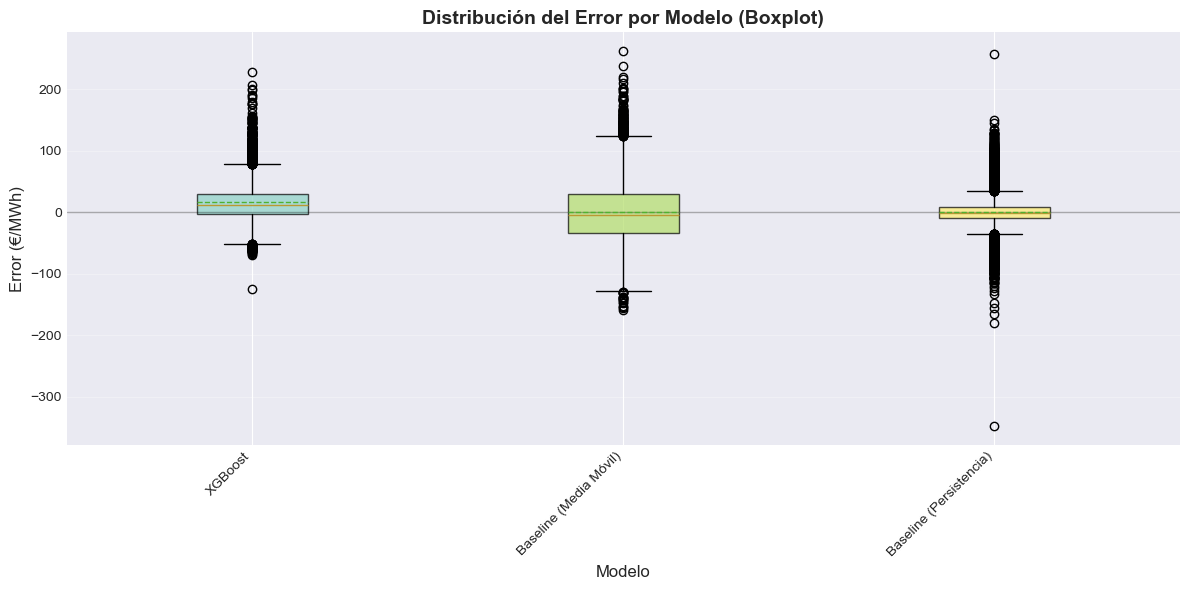

✓ Gráfico guardado en: ../../app/models/error_analysis/boxplot_errores_precio.png


In [15]:
# Boxplots comparativos del error
fig, ax = plt.subplots(figsize=(12, 6))

# Preparar datos para boxplot
data_for_boxplot = [errors[name] for name in errors.keys()]
labels = list(errors.keys())

bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True, 
                showmeans=True, meanline=True)

# Colorear las cajas
colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.set_title('Distribución del Error por Modelo (Boxplot)', fontsize=14, fontweight='bold')
ax.set_xlabel('Modelo', fontsize=12)
ax.set_ylabel('Error (€/MWh)', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(output_dir / 'boxplot_errores_precio.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado en: {output_dir / 'boxplot_errores_precio.png'}")


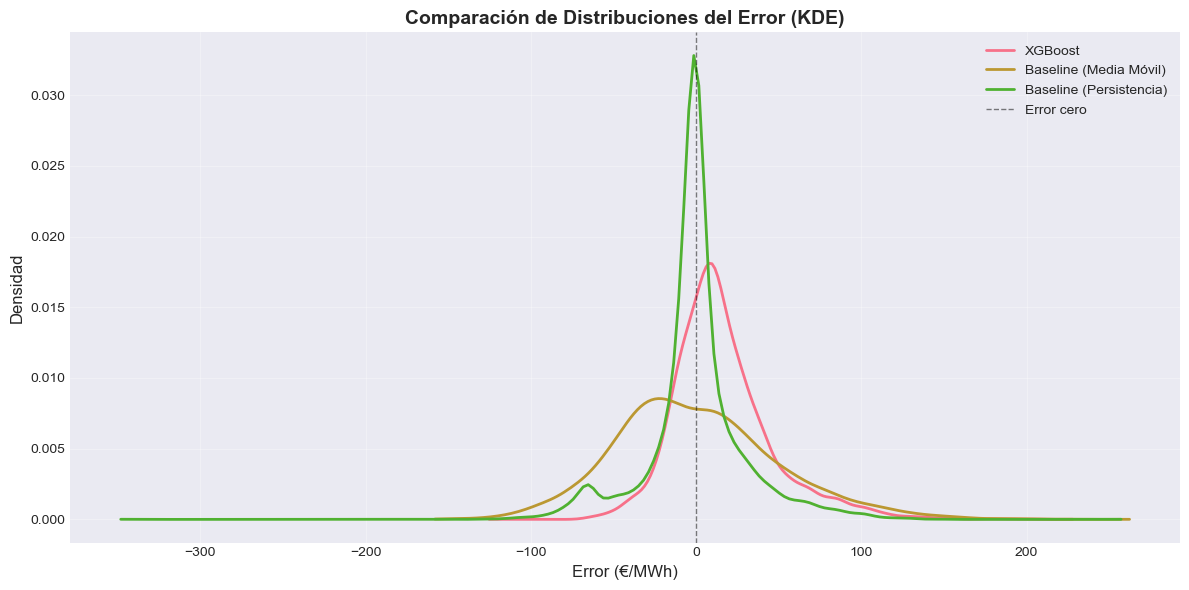

✓ Gráfico guardado en: ../../app/models/error_analysis/kde_comparacion_errores_precio.png


In [17]:
# Comparación de distribuciones con KDE superpuestas
fig, ax = plt.subplots(figsize=(12, 6))

from scipy import stats

for name, error in errors.items():
    try:
        kde = stats.gaussian_kde(error)
        x_range = np.linspace(error.min(), error.max(), 200)
        ax.plot(x_range, kde(x_range), label=name, linewidth=2)
    except:
        # Si falla KDE, usar histograma normalizado
        ax.hist(error, bins=50, alpha=0.3, label=name, density=True)

ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Error cero')
ax.set_title('Comparación de Distribuciones del Error (KDE)', fontsize=14, fontweight='bold')
ax.set_xlabel('Error (€/MWh)', fontsize=12)
ax.set_ylabel('Densidad', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'kde_comparacion_errores_precio.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado en: {output_dir / 'kde_comparacion_errores_precio.png'}")


## 10. Análisis de Percentiles (p5 y p90)


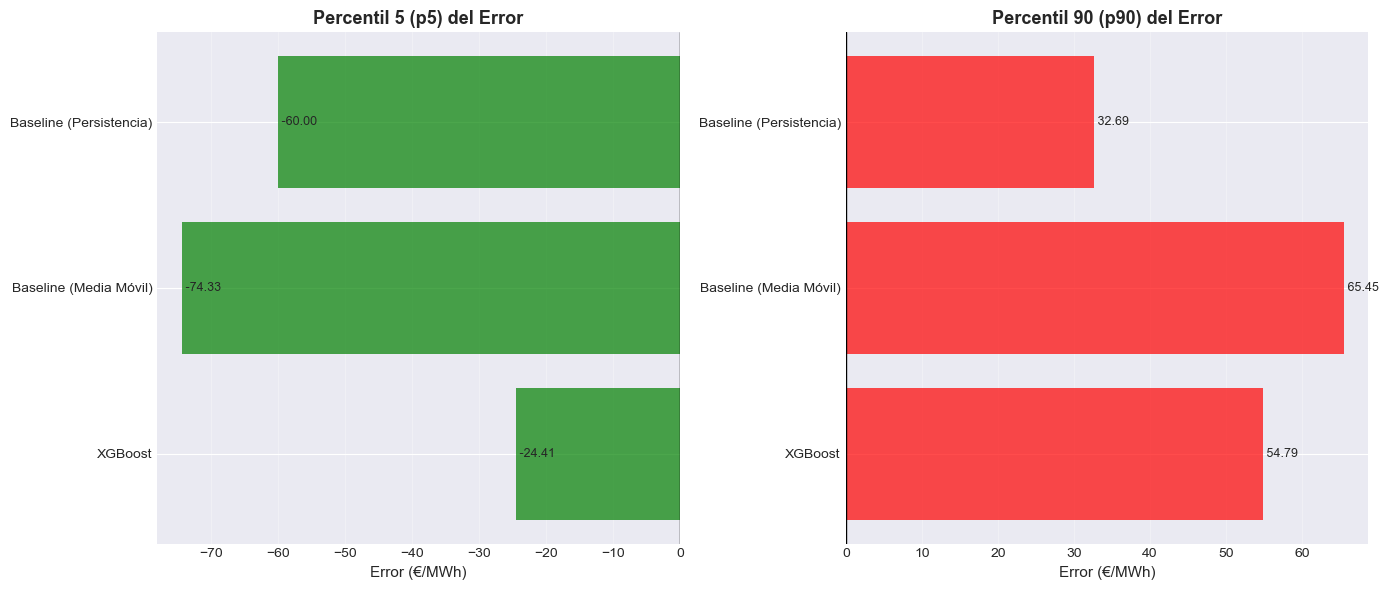

✓ Gráfico guardado en: ../../app/models/error_analysis/percentiles_errores_precio.png

Resumen de Percentiles:


,Modelo,p5,p90,Rango (p90-p5)
0,XGBoost,-24.41,54.79,79.20
1,Baseline (Media Móvil),-74.33,65.45,139.78
2,Baseline (Persistencia),-60.00,32.69,92.69


In [18]:
# Visualización de percentiles p5 y p90
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Percentil 5
p5_values = [np.percentile(errors[name], 5) for name in errors.keys()]
model_names = list(errors.keys())

bars1 = ax1.barh(model_names, p5_values, color='green', alpha=0.7)
ax1.axvline(0, color='black', linestyle='-', linewidth=1)
ax1.set_title('Percentil 5 (p5) del Error', fontsize=13, fontweight='bold')
ax1.set_xlabel('Error (€/MWh)', fontsize=11)
ax1.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars1, p5_values)):
    ax1.text(val, i, f' {val:.2f}', va='center', fontsize=9)

# Percentil 90
p90_values = [np.percentile(errors[name], 90) for name in errors.keys()]

bars2 = ax2.barh(model_names, p90_values, color='red', alpha=0.7)
ax2.axvline(0, color='black', linestyle='-', linewidth=1)
ax2.set_title('Percentil 90 (p90) del Error', fontsize=13, fontweight='bold')
ax2.set_xlabel('Error (€/MWh)', fontsize=11)
ax2.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars2, p90_values)):
    ax2.text(val, i, f' {val:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(output_dir / 'percentiles_errores_precio.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado en: {output_dir / 'percentiles_errores_precio.png'}")

# Tabla resumen de percentiles
print("\nResumen de Percentiles:")
percentiles_summary = pd.DataFrame({
    'Modelo': model_names,
    'p5': p5_values,
    'p90': p90_values,
    'Rango (p90-p5)': [p90 - p5 for p5, p90 in zip(p5_values, p90_values)]
})
display(percentiles_summary.round(2))


## 11. Resumen Final


In [19]:
print("="*80)
print("RESUMEN DEL ANÁLISIS DE ERRORES - PRECIO DE LA LUZ")
print("="*80)

print("\nMétricas principales (ordenadas por MAE):")
display(df_metrics[['Modelo', 'MAE', 'RMSE', 'p5', 'p90']].round(2))

print("\nMejor modelo según MAE:")
best_model = df_metrics.iloc[0]
print(f"  Modelo: {best_model['Modelo']}")
print(f"  MAE: {best_model['MAE']:.2f} €/MWh")
print(f"  RMSE: {best_model['RMSE']:.2f} €/MWh")
print(f"  p5: {best_model['p5']:.2f} €/MWh")
print(f"  p90: {best_model['p90']:.2f} €/MWh")

print(f"\n✓ Todos los resultados guardados en: {output_dir}")
print("="*80)


RESUMEN DEL ANÁLISIS DE ERRORES - PRECIO DE LA LUZ

Métricas principales (ordenadas por MAE):


,Modelo,MAE,RMSE,p5,p90
2,Baseline (Persistencia),18.73,30.16,-60.00,32.69
0,XGBoost,24.42,34.58,-24.41,54.79
1,Baseline (Media Móvil),38.99,49.64,-74.33,65.45



Mejor modelo según MAE:
  Modelo: Baseline (Persistencia)
  MAE: 18.73 €/MWh
  RMSE: 30.16 €/MWh
  p5: -60.00 €/MWh
  p90: 32.69 €/MWh

✓ Todos los resultados guardados en: ../../app/models/error_analysis


## Notas para Ejecución en Google Colab

Si necesitas ejecutar este notebook en Google Colab, asegúrate de:

1. Subir los archivos necesarios:
   - Modelo entrenado: `app/models/precio_luz_xgb.pkl`
   - Datos de precios: `data/precio_luz/data_parquet_clean/precios_luz/` (todos los archivos por año)
   - Datos REE: `data/ree/data_parquet_clean/` (demanda, generacion, emision, almacenamiento)

2. Instalar dependencias:
```python
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost scipy pyarrow
!pip install tensorflow  # Solo si quieres analizar modelos LSTM/GRU
```

3. Ajustar las rutas según tu estructura de archivos en Colab
